## EfficientNetB3

In [1]:
# ✅ Step 1: Import Required Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-29 10:42:51.524014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751193771.729792      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751193771.792679      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Paths (update if different)
base_dir = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2'  # Change if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image dimensions
IMG_SIZE = 224 
BATCH_SIZE = 32
NUM_CLASSES = 5

In [3]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Only resizing + EfficientNet normalization (no augmentation)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create generators
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 115241 images belonging to 5 classes.
Found 14227 images belonging to 5 classes.
Found 14201 images belonging to 5 classes.


In [4]:
# Load EfficientNetB3 base model
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze for fine-tuning
base_model.trainable = True

# Custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1751193879.830358      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751193879.831095      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
checkpoint_cb = callbacks.ModelCheckpoint('/kaggle/working/best_efficientnetb3_dr.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1751193969.039430      82 service.cc:148] XLA service 0x7bed8005f9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751193969.040328      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751193969.040354      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751193977.135763      82 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751193992.726207      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751193992.874385      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751193993.444394      82 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

2750/3602 ━━━━━━━━━━━━━━━━━━━━ 4:06 290ms/step - accuracy: 0.5371 - loss: 1.3646

E0000 00:00:1751194839.564024      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751194839.704206      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1388s 346ms/step - accuracy: 0.5607 - loss: 1.2872 - val_accuracy: 0.7621 - val_loss: 0.6798 - learning_rate: 1.0000e-04
Epoch 2/100
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 995s 276ms/step - accuracy: 0.7440 - loss: 0.7014 - val_accuracy: 0.7838 - val_loss: 0.6193 - learning_rate: 1.0000e-04
Epoch 3/100
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 995s 276ms/step - accuracy: 0.7988 - loss: 0.5625 - val_accuracy: 0.7903 - val_loss: 0.6186 - learning_rate: 1.0000e-04
Epoch 4/100
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 991s 275ms/step - accuracy: 0.8451 - loss: 0.4350 - val_accuracy: 0.7884 - val_loss: 0.6486 - learning_rate: 1.0000e-04
Epoch 5/100
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8830 - loss: 0.3294
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 993s 276ms/step - accuracy: 0.8830 - loss: 0.3294 - val_accuracy: 0.7931 - val_loss: 0.6699 - learning_rate: 1.0000e-04
Epoch 6/100
3602/3602 ━━━━━━━━━━━━━━━━━━

In [6]:
import pickle

# Save history to disk
with open("E3_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

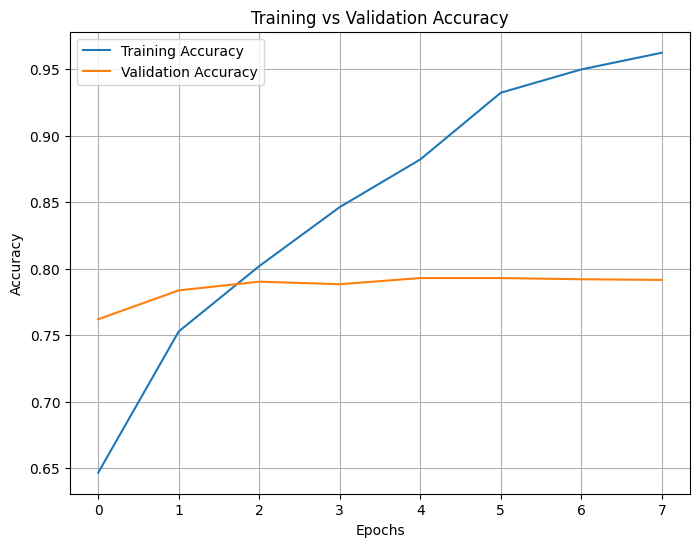

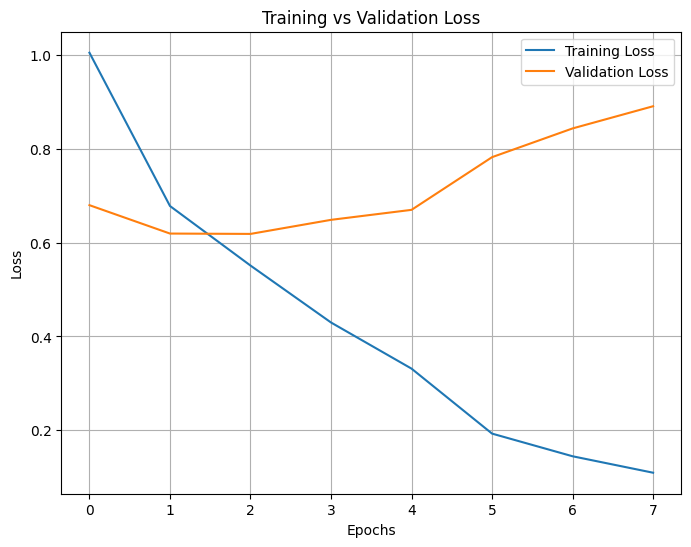

In [7]:
history_data = history.history

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

444/444 ━━━━━━━━━━━━━━━━━━━━ 150s 316ms/step
📊 Classification Report:
              precision    recall  f1-score   support

           0     0.8450    0.9529    0.8957      6896
           1     0.4144    0.4302    0.4221      1862
           2     0.4825    0.3488    0.4049      2999
           3     0.4855    0.3436    0.4024       978
           4     0.6599    0.7347    0.6953      1466

    accuracy                         0.6923     14201
   macro avg     0.5775    0.5620    0.5641     14201
weighted avg     0.6681    0.6923    0.6753     14201



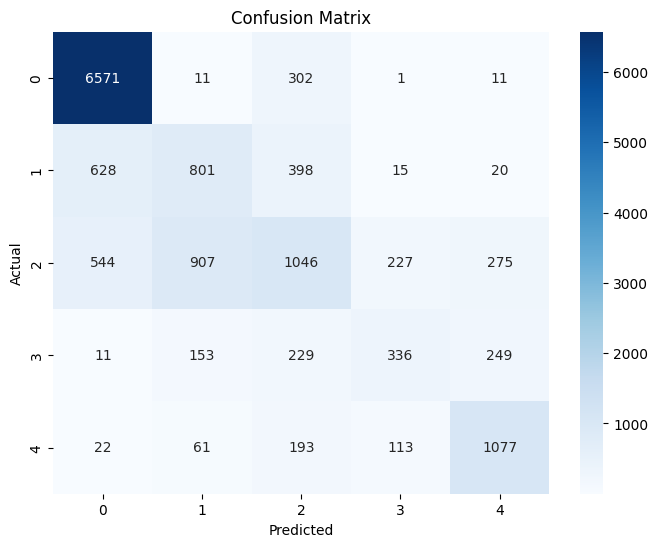

🧠 Quadratic Weighted Kappa (QWK): 0.8144


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# QWK Score
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"🧠 Quadratic Weighted Kappa (QWK): {qwk:.4f}")